In [1]:
import argparse
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from model import BrainNetworkTransformer
from dataloader import get_dataloader
parser = argparse.ArgumentParser()
import numpy as np
import os
parser.add_argument('--task_name', type=str, default='189Recurrentvs427NC', help='Name of the task') # 232FEDNvs394NC  189Recurrentvs427NC   119FEDNvs72Recurrent 848MDDvs794NC
parser.add_argument('--altas_name', type=str, default='AAL', help='Name of the altas') # CC200 Dosenbach HO AAL
base_path = '/home/rendy/fMRI/DATASETS/MDD'
args, unknown = parser.parse_known_args()
data_path = f"{base_path}/{args.task_name}/{args.task_name}_{args.altas_name}.npy"
csv_path = f"{base_path}/{args.task_name}/{args.task_name}_{args.altas_name}.csv"
#---不同模板---
parser.add_argument('--data_path', type=str, default=data_path, help='Path to the data file')
parser.add_argument('--csv_path', type=str, default=csv_path, help='Path to the CSV file')

# ------experiment config------ #
parser.add_argument('--n_split', type=int, default=5, help='n-fold cross validation')
parser.add_argument('--seed', type=int, default=2024, help='random seed')
parser.add_argument('--device', type=str, default='cuda:0', help='specify cuda devices')

# ------Transformer config------ #
parser.add_argument('--num_epochs', type=int, default=400, help='num_epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--saved_model_dir', type=str, default='./saved_model/', help='root of saved_model')


# ------ext feature------ #
parser.add_argument('--ext_featuresize', type=int, default=16, help='exc_featuresize')
# ------GNN config------ #

parser.add_argument('--gcn_num_epochs', type=int, default=1000, help='num_epochs')
parser.add_argument('--numeric_features', type=str, default=['Age', 'Edu'], help='numeric features')
parser.add_argument('--text_features', type=str, default=['Site', 'Sex'], help='text features ')
parser.add_argument('--num_features', type=int, default=16, help='num_features')# 和ext_featuresize一样，一会改一下
parser.add_argument('--nhid', type=int, default=256, help='hidden size ')
parser.add_argument('--dropout_ratio', type=float, default=0.3, help='dropout ratio')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')

args, unknown = parser.parse_known_args()

#---Grad CAM---
def forward_hook(module, input, output):
    setattr(module, '_activations', output.detach())

def backward_hook(module, grad_in, grad_out):
    setattr(module, '_gradients', grad_out[0].detach())

def grad_cam(model, input_tensor, target_class):
    output,_ = model(input_tensor)
    activations = model.reduce_dim3._activations
    gradients = model.reduce_dim3._gradients
    # print("target_class type:", type(target_class)) 
    target_score = output[:, target_class]
    model.zero_grad()
    target_score.mean().backward()

    gradients = gradients.detach()
    activations = activations.detach()

    pooled_gradients = torch.mean(gradients, dim=[0, 2])
    for i in range(activations.shape[1]):
        activations[:, i, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=2)
    heatmap = torch.relu(heatmap)
    heatmap /= (torch.max(heatmap) + 1e-8)

    return heatmap.cpu().numpy()


/home/rendy/.conda/envs/geometric/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 计算MDD与HC的平均热图
dataloaders_list = get_dataloader(args)
saved_model_dir = os.path.join(args.saved_model_dir, f"{args.task_name}_{args.altas_name}")

heatmap_list_MDD = []
heatmap_list_HC = []
heatmap_list_all = []

for fold, (train_dataloader, test_dataloader) in enumerate(dataloaders_list):
    model = BrainNetworkTransformer(args).to(args.device)
    forward_handle = model.reduce_dim3.register_forward_hook(forward_hook)
    backward_handle = model.reduce_dim3.register_full_backward_hook(backward_hook)
    fold_model_path = os.path.join(saved_model_dir, f'best_acc_model_{fold}.pth')
    model.load_state_dict(torch.load(fold_model_path))
    model.eval()

    for index, (time_series, node_feature, labels, indices) in enumerate(test_dataloader):
        time_series, node_feature, labels = time_series.to(args.device), node_feature.to(args.device), labels.to(args.device)
        for i in range(node_feature.shape[0]):
            single_feature = node_feature[i:i+1]  # 提取单个样本的特征
            single_label = labels[i].argmax().unsqueeze(0)   # 这是独热编码标签，形状类似于 [0, 1]

            # 转换独热编码为类别索引
            # target_class = single_label.argmax().item()  # 提取索引
            predict, _ = model(single_feature)
            # 使用类别索引计算损失
            loss = torch.nn.CrossEntropyLoss(reduction='sum')(predict, single_label)
            loss.backward()
            # 传递类别索引的整数值给 grad_cam
            heatmap = grad_cam(model, single_feature, single_label.item())

            heatmap_list_all.append(heatmap)

            if single_label.item() == 1:  # 假设标签1为患病
                heatmap_list_MDD.append(heatmap)
            else:
                heatmap_list_HC.append(heatmap)

    forward_handle.remove()
    backward_handle.remove()

# 计算每个组的平均热图
heatmap_avg_MDD = np.mean(heatmap_list_MDD, axis=0)
heatmap_avg_HC = np.mean(heatmap_list_HC, axis=0)
heatmap_avg_all = np.mean(heatmap_list_all, axis=0)
heatmap_differences = np.abs(heatmap_avg_MDD - heatmap_avg_HC)


In [5]:
import numpy as np

# 假设 heatmap_avg_MDD、heatmap_avg_HC 和 heatmap_diff 是你的 NumPy 数组

# 保存 heatmap_avg_MDD
np.savetxt('heatmap_recurrent_MDD.txt', heatmap_avg_MDD, fmt='%f')

# 保存 heatmap_avg_HC
np.savetxt('heatmap_recurrent_HC.txt', heatmap_avg_HC, fmt='%f')

# 保存 heatmap_diff
np.savetxt('heatmap_recurrent_diff.txt', heatmap_differences, fmt='%f')


In [3]:
# 打印出前十的latex表格代码------------------------------------------------------------------------------------------
import pandas as pd
def get_top_values(tensor):
    squeezed_tensor = tensor.squeeze()
    top_values, top_indices = torch.topk(squeezed_tensor, 10)
    return top_indices.numpy(), top_values.numpy()

indices_mdd, values_mdd = get_top_values(torch.from_numpy(heatmap_avg_MDD))
indices_hc, values_hc = get_top_values(torch.from_numpy(heatmap_avg_HC))
indices_all, values_all = get_top_values(torch.from_numpy(heatmap_avg_all))

top_diff_values, top_diff_indices = torch.topk(torch.from_numpy(heatmap_differences.squeeze()), 10)

df_label = pd.read_csv('/home/rendy/rdyBrainNetTransformer/WithGNN/altas_label/AAL116_label.csv')
def create_dataframe(indices, values,df_label):
    # 根据indices从label文件中拿出名称
    labels = df_label.set_index('index').loc[indices+1]['label']
    df = pd.DataFrame({
        'Region ID': indices,
        'Region Name': labels,  # 空白的region name
        'Value': values
    })
    return df

df_mdd = create_dataframe(indices_mdd, values_mdd,df_label)
df_hc = create_dataframe(indices_hc, values_hc,df_label)
df_all = create_dataframe(indices_all, values_all,df_label)
df_diff = create_dataframe(top_diff_indices, top_diff_values,df_label)

latex_mdd = df_mdd.to_latex(index=False, header=True)
latex_hc = df_hc.to_latex(index=False, header=True)
latex_all = df_all.to_latex(index=False, header=True)
latex_diff = df_diff.to_latex(index=False, header=True)
# print(args.task_name)
# print("MDD Contribution Top 10 LaTeX Code:")
# print(latex_mdd)
# print("\nHC Contribution Top 10 LaTeX Code:")
# print(latex_hc)
# print("\nAll Samples Contribution Top 10 LaTeX Code:")
# print(latex_all)
# print("Top 10 Differences between MDD and HC:")
# print(latex_diff)

Shape of heatmap_avg_MDD: (1, 116)


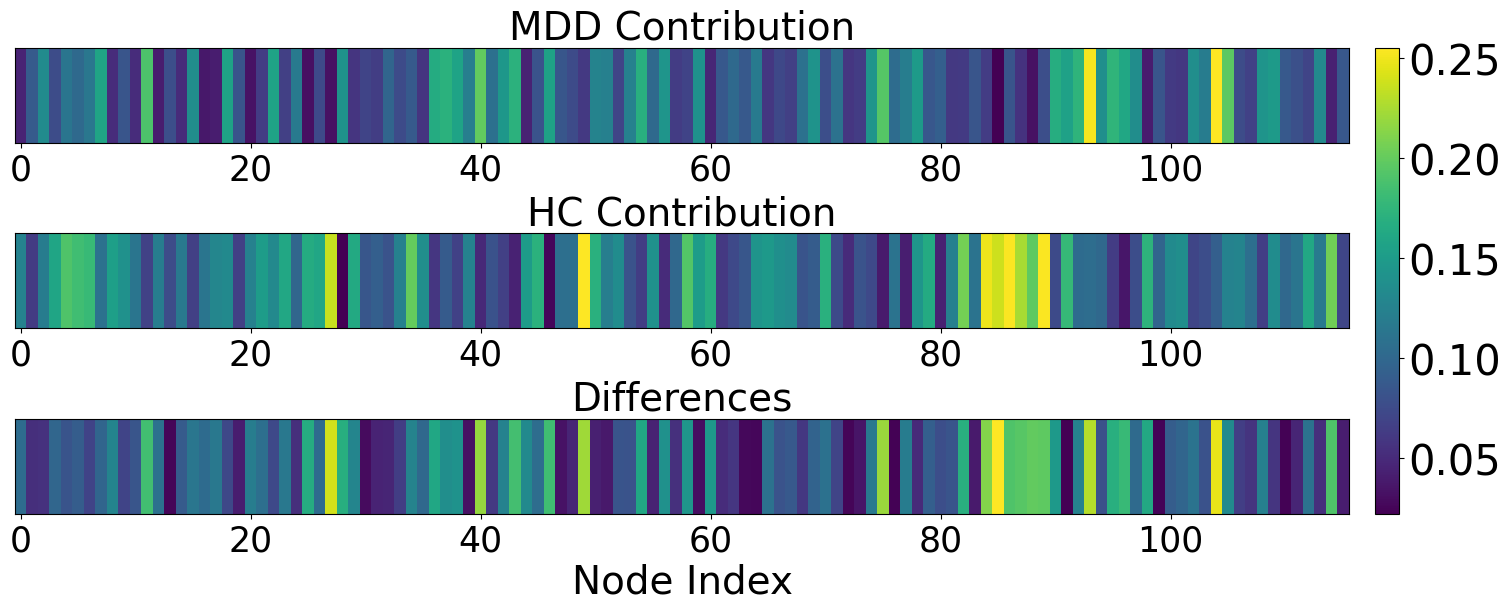

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(15, 6), constrained_layout=True)  # 增加了图的高度
cmap = 'viridis'

# Example data shapes (assuming they are 2D already)
print("Shape of heatmap_avg_MDD:", heatmap_avg_MDD.shape)

# Ensure conversion to numpy if they are tensors and use imshow directly on 2D data
img1 = axs[0].imshow(heatmap_avg_MDD, aspect='auto', cmap=cmap)
axs[0].set_title("MDD Contribution", fontsize=28)  # 增加了标题字体大小
axs[0].set_yticks([])  # Hides y-axis ticks

img2 = axs[1].imshow(heatmap_avg_HC, aspect='auto', cmap=cmap)
axs[1].set_title("HC Contribution", fontsize=28)
axs[1].set_yticks([])

# img3 = axs[2].imshow(heatmap_avg_all, aspect='auto', cmap=cmap)
# axs[2].set_title("All Samples Contribution", fontsize=28)
# axs[2].set_yticks([])

img4 = axs[2].imshow(heatmap_differences, aspect='auto', cmap=cmap)
axs[2].set_title("Differences", fontsize=28)
axs[2].set_yticks([])

# 设置色标和其字体大小
cbar = fig.colorbar(img1, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=30)  # 调整色标刻度字体大小

for ax in axs:
    ax.tick_params(axis='x', labelsize=25) 
# 设置 x 轴标签并调整字体大小
axs[2].set_xlabel("Node Index", fontsize=28)

plt.show()


In [5]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/rendy/.conda/envs/geometric/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

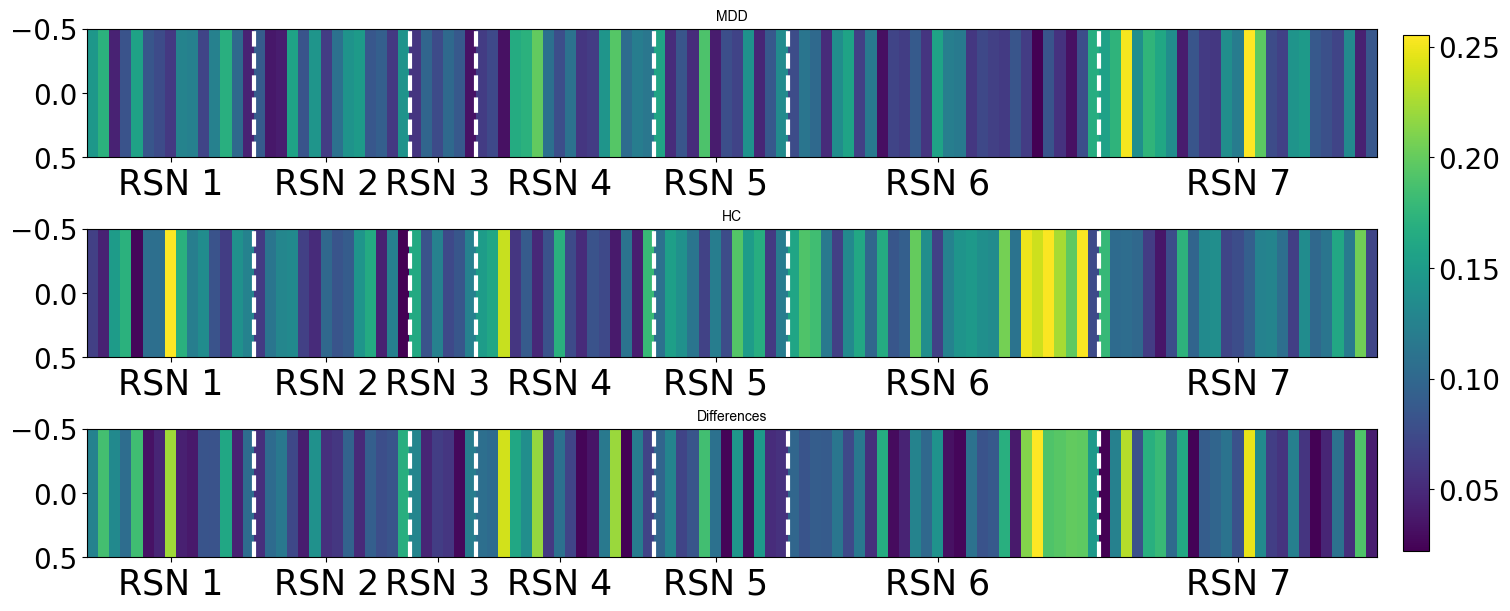

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置字体路径
font_path = '/home/rendy/rdyBrainNetTransformer/WithGNN/arial.ttf'

# 使用指定的字体
font = FontProperties(fname=font_path)

# 导入数据
rsn_data = pd.read_csv('/home/rendy/rdyBrainNetTransformer/WithGNN/altas_label/AAL116_rsn7.csv')
grouped_rsn = rsn_data.groupby('rsn')['index'].apply(list)

# 重新排序数据以聚集相同RSN的节点
sorted_indices = sorted(rsn_data['index'] - 1, key=lambda x: rsn_data.iloc[x]['rsn'])  # 1-based index转为0-based
rsn_labels_sorted = [rsn_data.iloc[x]['rsn'] for x in sorted_indices]

# 重新排列热图数据
heatmap_avg_MDD_sorted = heatmap_avg_MDD[:, sorted_indices]
heatmap_avg_HC_sorted = heatmap_avg_HC[:, sorted_indices]
heatmap_avg_all_sorted = heatmap_avg_all[:, sorted_indices]
heatmap_diff = np.abs(heatmap_avg_MDD_sorted - heatmap_avg_HC_sorted)

# 保存数据
np.savetxt('heatmap_recurrent_MDD.txt', heatmap_avg_MDD_sorted, fmt='%f')
# 保存 heatmap_avg_HC
np.savetxt('heatmap_recurrent_HC.txt', heatmap_avg_HC_sorted, fmt='%f')
# 保存 heatmap_diff
np.savetxt('heatmap_recurrent_diff.txt', heatmap_diff, fmt='%f')

# 设置绘图
fig, axs = plt.subplots(3, 1, figsize=(15, 6), constrained_layout=True)
cmap = 'viridis'  # 选择适合的颜色映射

# 绘制每个热图
axs[0].imshow(heatmap_avg_MDD_sorted, aspect='auto', cmap=cmap)
axs[0].set_title("MDD", fontsize=30,fontproperties=font)  # 调整标题字体大小

axs[1].imshow(heatmap_avg_HC_sorted, aspect='auto', cmap=cmap)
axs[1].set_title("HC", fontsize=30,fontproperties=font)  # 调整标题字体大小

im2 = axs[2].imshow(heatmap_diff, aspect='auto', cmap=cmap)
axs[2].set_title("Differences", fontsize=30, fontproperties=font)

# 添加色标并调整色标的字体大小
cbar = fig.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=20)  # 调整色标刻度字体大小

# 计算RSN中点并标注
rsn_midpoints = []
rsn_labels = []
current_rsn = rsn_labels_sorted[0]
start_index = 0
rsn_ends = []  # 收集RSN边界索引
for i, rsn in enumerate(rsn_labels_sorted + [None], 1):
    if rsn != current_rsn:
        end_index = i - 1
        midpoint = (start_index + end_index) // 2
        rsn_midpoints.append(midpoint)
        rsn_labels.append(f"RSN {current_rsn}")
        rsn_ends.append(end_index)  # 收集边界
        start_index = i
        current_rsn = rsn

# 在每个RSN之间画分界线
for end in rsn_ends[:-1]:  # 最后一个分界线不需要绘制
    for ax in axs:
        ax.axvline(x=end + 0.5, color='white', linestyle='--', linewidth=3)

# 设置x轴，并调整刻度标签的字体大小
for ax in axs:
    ax.set_xticks(rsn_midpoints)
    ax.set_xticklabels(rsn_labels, rotation=0, ha='center', fontsize=25)  # 调整x轴刻度标签字体大小

# 调整y轴刻度标签的字体大小（如果有）
for ax in axs:
    ax.tick_params(axis='y', labelsize=20)

plt.show()


In [9]:
rsn_ends
rsn_labels
rsn_midpoints
rsn_ends

[14, 28, 34, 50, 62, 90, 116]

In [18]:
grouped_rsn = rsn_data.groupby('rsn')['index'].apply(list)
rsn_averages_diff = {}
heatmap_diff_tensor = torch.tensor(heatmap_diff, dtype=torch.float)
for rsn, indices in grouped_rsn.items():
    # 将索引转换为0-based，然后转换为tensor
    indices_tensor = torch.tensor([i - 1 for i in indices], dtype=torch.long)  # 1-based to 0-based index
    rsn_averages_diff[f'RSN {rsn}'] = torch.mean(heatmap_diff_tensor[:, indices_tensor], dim=1)
print("Average differences for each RSN:")
for rsn, avg_diff in rsn_averages_diff.items():
    print(f"{rsn}: {avg_diff.numpy()}")

Average differences for each RSN:
RSN 1: [0.07661409]
RSN 2: [0.07557433]
RSN 3: [0.09179082]
RSN 4: [0.0579669]
RSN 5: [0.12440065]
RSN 6: [0.0900206]
RSN 7: [0.09237087]


In [107]:
# 方差齐性检验
# heatmap_list_MDD 是(样本数, 1, 脑区数)
from scipy.stats import levene, shapiro

# 假设 heatmap_list_MDD 和 heatmap_list_HC 已经是加载好的 NumPy 数组
# 并且它们的形状是 (样本数, 1, 脑区数)，我们需要将它们调整为 (样本数, 脑区数)
heatmap_list_MDD = np.squeeze(heatmap_list_MDD)
heatmap_list_HC = np.squeeze(heatmap_list_HC)
num_brain_areas = heatmap_list_MDD.shape[1]

# 初始化字典来存储每个脑区的检验结果
levene_results = {}
shapiro_results_MDD = {}
shapiro_results_HC = {}

num_areas_with_equal_variances = 0
num_areas_normal_MDD = 0
num_areas_normal_HC = 0

# 遍历每一个脑区进行Levene's Test和Shapiro-Wilk Test
for i in range(num_brain_areas):
    data_MDD = heatmap_list_MDD[:, i]
    data_HC = heatmap_list_HC[:, i]

    # 方差齐性检验
    stat_levene, p_value_levene = levene(data_MDD, data_HC)
    levene_results[f'Brain Area {i+1}'] = {'Statistic': stat_levene, 'P-value': p_value_levene}
    if p_value_levene > 0.05:
        num_areas_with_equal_variances += 1

    # 正态性检验 (MDD)
    stat_shapiro_MDD, p_value_shapiro_MDD = shapiro(data_MDD)
    shapiro_results_MDD[f'Brain Area {i+1}'] = {'Statistic': stat_shapiro_MDD, 'P-value': p_value_shapiro_MDD}
    if p_value_shapiro_MDD > 0.05:
        num_areas_normal_MDD += 1

    # 正态性检验 (HC)
    stat_shapiro_HC, p_value_shapiro_HC = shapiro(data_HC)
    shapiro_results_HC[f'Brain Area {i+1}'] = {'Statistic': stat_shapiro_HC, 'P-value': p_value_shapiro_HC}
    if p_value_shapiro_HC > 0.05:
        num_areas_normal_HC += 1

# 输出结果
print(f"Number of brain areas with equal variances: {num_areas_with_equal_variances}/{num_brain_areas}")
print(f"Number of MDD brain areas with normal distribution: {num_areas_normal_MDD}/{num_brain_areas}")
print(f"Number of HC brain areas with normal distribution: {num_areas_normal_HC}/{num_brain_areas}")



Number of brain areas with equal variances: 30/116
Number of MDD brain areas with normal distribution: 0/116
Number of HC brain areas with normal distribution: 0/116


In [110]:
# 显著脑区的数量
from scipy.stats import mannwhitneyu

# 假设 heatmap_list_MDD 和 heatmap_list_HC 已经是加载好的 NumPy 数组
# 并且它们的形状是 (样本数, 1, 脑区数)，我们需要将它们调整为 (样本数, 脑区数)
heatmap_list_MDD = np.squeeze(heatmap_list_MDD)
heatmap_list_HC = np.squeeze(heatmap_list_HC)
num_brain_areas = heatmap_list_MDD.shape[1]

# 存储每个脑区的检验结果
mann_whitney_results = {}

# 用于计数统计显著的脑区数量
num_significant_areas = 0

# 遍历每一个脑区进行Mann-Whitney U Test
for i in range(num_brain_areas):
    data_MDD = heatmap_list_MDD[:, i]
    data_HC = heatmap_list_HC[:, i]
    stat, p_value = mannwhitneyu(data_MDD, data_HC, alternative='two-sided')
    mann_whitney_results[f'Brain Area {i+1}'] = {'Statistic': stat, 'P-value': p_value}
    if p_value < 0.05:
        num_significant_areas += 1

# 输出显著脑区的数量
print(f"Number of significant brain areas: {num_significant_areas}/{num_brain_areas}")

from statsmodels.stats.multitest import multipletests

# 假设 p_values 是我们从Mann-Whitney U测试中得到的p值列表
p_values = [mann_whitney_results[area]['P-value'] for area in mann_whitney_results]

# 应用Bonferroni校正
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# 计算校正后的显著脑区数量
num_significant_areas_corrected = sum(reject)

print(f"Number of significant brain areas after Bonferroni correction: {num_significant_areas_corrected}/{num_brain_areas}")



Number of significant brain areas: 88/116
Number of significant brain areas after Bonferroni correction: 59/116


In [19]:
def forward_hook(module, input, output):
    setattr(module, '_activations', output.detach())

def backward_hook(module, grad_in, grad_out):
    setattr(module, '_gradients', grad_out[0].detach())

def grad_cam(model, input_tensor, target_class):
    output,_ = model(input_tensor)
    activations = model.reduce_dim3._activations
    gradients = model.reduce_dim3._gradients
    # print("target_class type:", type(target_class)) 
    target_score = output[:, target_class]
    model.zero_grad()
    target_score.mean().backward()

    gradients = gradients.detach()
    activations = activations.detach()

    pooled_gradients = torch.mean(gradients, dim=[0, 2])
    for i in range(activations.shape[1]):
        activations[:, i, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=2)
    heatmap = torch.relu(heatmap)
    heatmap /= (torch.max(heatmap) + 1e-8)

    return heatmap.cpu().numpy()

class HeatmapGroup:
    def __init__(self, node_size):
        self.sum = torch.zeros(node_size)
        self.count = 0
    
    def update(self, heatmap):
        if heatmap is not None:
            self.sum += heatmap
            self.count += 1
        else:
            print("Warning: Received None heatmap")
    
    def average(self):
        return self.sum / self.count if self.count > 0 else torch.zeros_like(self.sum)

def compute_difference(heatmap1, heatmap2):
    return torch.abs(heatmap1 - heatmap2)


dataloaders_list = get_dataloader(args)
saved_model_dir = os.path.join(args.saved_model_dir, f"{args.task_name}_{args.altas_name}")
Phenotypic = pd.read_csv('/home/rendy/fMRI/DATASETS/MDD/848MDDvs794NC/848MDDvs794NC_AAL.csv', index_col='Index')

groups = {
    'MDD_male': HeatmapGroup(args.node_sz),
    'MDD_female': HeatmapGroup(args.node_sz),
    'HC_male': HeatmapGroup(args.node_sz),
    'HC_female': HeatmapGroup(args.node_sz),
    'MDD_young': HeatmapGroup(args.node_sz),
    'MDD_middle_aged': HeatmapGroup(args.node_sz),
    'MDD_senior': HeatmapGroup(args.node_sz),
    'HC_young': HeatmapGroup(args.node_sz),
    'HC_middle_aged': HeatmapGroup(args.node_sz),
    'HC_senior': HeatmapGroup(args.node_sz)
}

for fold, (train_dataloader, test_dataloader) in enumerate(dataloaders_list):
    model = BrainNetworkTransformer(args).to(args.device)
    forward_handle = model.reduce_dim3.register_forward_hook(forward_hook)
    backward_handle = model.reduce_dim3.register_full_backward_hook(backward_hook)
    fold_model_path = os.path.join(saved_model_dir, f'best_acc_model_{fold}.pth')
    model.load_state_dict(torch.load(fold_model_path))
    model.eval()
    
    for index, (time_series, node_feature, labels, indices) in enumerate(test_dataloader):
        
        time_series, node_feature, labels = time_series.to(args.device), node_feature.to(args.device), labels.to(args.device)
        indices_np = indices.numpy().astype(int)  # 将张量转换为 Numpy 数组
        sample_ages = Phenotypic.loc[indices_np, 'Age'].values
        sample_sexes = Phenotypic.loc[indices_np, 'Sex'].values

        for i in range(node_feature.shape[0]):
            single_feature = node_feature[i:i+1]  # 提取单个样本的特征
            single_label = labels[i].argmax().unsqueeze(0)   # 这是独热编码标签，形状类似于 [0, 1]
            
            predict, _ = model(single_feature)

            # 使用类别索引计算损失
            loss = torch.nn.CrossEntropyLoss(reduction='sum')(predict, single_label)
            loss.backward()
            # 传递类别索引的整数值给 grad_cam
            heatmap = grad_cam(model, single_feature, single_label.item())
            if np.isnan(heatmap).any():
                print(f"NaN detected in heatmap output for sample {indices_np[i]}")
                continue 

            age_group = 'young' if 18 <= sample_ages[i] <= 30 else 'middle_aged' if 31 <= sample_ages[i] <= 60 else 'senior'
            sex = 'male' if sample_sexes[i] == 0 else 'female'
            label = 'MDD' if single_label.item() == 1 else 'HC'
            
            groups[f'{label}_{sex}'].update(heatmap)
            groups[f'{label}_{age_group}'].update(heatmap)

    forward_handle.remove()
    backward_handle.remove()

averages = {key: group.average() for key, group in groups.items()}
differences = {
    'MDD_vs_HC_male': compute_difference(averages['MDD_male'], averages['HC_male']),
    'MDD_vs_HC_female': compute_difference(averages['MDD_female'], averages['HC_female']),
    'MDD_vs_HC_young': compute_difference(averages['MDD_young'], averages['HC_young']),
    'MDD_vs_HC_middle_aged': compute_difference(averages['MDD_middle_aged'], averages['HC_middle_aged']),
    'MDD_vs_HC_senior': compute_difference(averages['MDD_senior'], averages['HC_senior'])
}

In [178]:
averages['MDD_male']

tensor([[0.0801, 0.0920, 0.0291, 0.1016, 0.1356, 0.1128, 0.0697, 0.0836, 0.1218,
         0.0542, 0.1478, 0.1924, 0.0278, 0.0459, 0.1208, 0.1116, 0.0208, 0.0608,
         0.1150, 0.0457, 0.0813, 0.0320, 0.0657, 0.1303, 0.0572, 0.0511, 0.0588,
         0.0886, 0.1939, 0.1123, 0.0799, 0.0778, 0.1688, 0.1049, 0.1084, 0.1010,
         0.2833, 0.2002, 0.1086, 0.0337, 0.1568, 0.0859, 0.1625, 0.2003, 0.0661,
         0.0379, 0.1002, 0.0690, 0.1295, 0.1067, 0.2228, 0.2641, 0.0224, 0.0746,
         0.1007, 0.0161, 0.1984, 0.0840, 0.0475, 0.0711, 0.0376, 0.0274, 0.1087,
         0.1471, 0.1050, 0.1351, 0.0996, 0.0850, 0.2401, 0.1281, 0.1625, 0.1033,
         0.0557, 0.0635, 0.1184, 0.0421, 0.1138, 0.1855, 0.0847, 0.0339, 0.0959,
         0.0671, 0.0332, 0.0705, 0.1287, 0.0538, 0.1465, 0.0523, 0.2508, 0.0632,
         0.1667, 0.1759, 0.1821, 0.1851, 0.1032, 0.2104, 0.1735, 0.0797, 0.0161,
         0.0592, 0.0648, 0.0709, 0.0602, 0.0651, 0.1977, 0.0903, 0.0830, 0.0260,
         0.1579, 0.1308, 0.0

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有了differences字典中的这些数据
heatmap_diff_male = differences['MDD_vs_HC_male']
heatmap_diff_female = differences['MDD_vs_HC_female']
heatmap_diff_young = differences['MDD_vs_HC_young']
heatmap_diff_middle_aged = differences['MDD_vs_HC_middle_aged']
heatmap_diff_senior = differences['MDD_vs_HC_senior']

print("Shape of heatmap_diff_male:", heatmap_diff_male.shape)
print("Min/Max of heatmap_diff_male:", heatmap_diff_male.min(), heatmap_diff_male.max())


# 读取RSN数据并排序
rsn_data = pd.read_csv('/home/rendy/rdyBrainNetTransformer/WithGNN/altas_label/AAL116_rsn7.csv')
sorted_indices = sorted(rsn_data['index'] - 1, key=lambda x: rsn_data.iloc[x]['rsn'])
rsn_labels_sorted = [rsn_data.iloc[x]['rsn'] for x in sorted_indices]

# 根据排序重排热图数据
heatmap_diff_male_sorted = heatmap_diff_male[:, sorted_indices]
heatmap_diff_female_sorted = heatmap_diff_female[:, sorted_indices]
heatmap_diff_young_sorted = heatmap_diff_young[:, sorted_indices]
heatmap_diff_middle_aged_sorted = heatmap_diff_middle_aged[:, sorted_indices]
heatmap_diff_senior_sorted = heatmap_diff_senior[:, sorted_indices]




Shape of heatmap_diff_male: torch.Size([1, 116])
Min/Max of heatmap_diff_male: tensor(0.0008) tensor(0.2738)


In [ ]:
np.savetxt('heatmap_male_rsn.txt', heatmap_diff_male_sorted, fmt='%f')
np.savetxt('heatmap_female_rsn.txt', heatmap_diff_female_sorted, fmt='%f')
np.savetxt('heatmap_young_rsn.txt', heatmap_diff_young_sorted, fmt='%f')
np.savetxt('heatmap_middle_aged_rsn.txt', heatmap_diff_middle_aged_sorted, fmt='%f')
np.savetxt('heatmap_senior_rsn.txt', heatmap_diff_senior_sorted, fmt='%f')

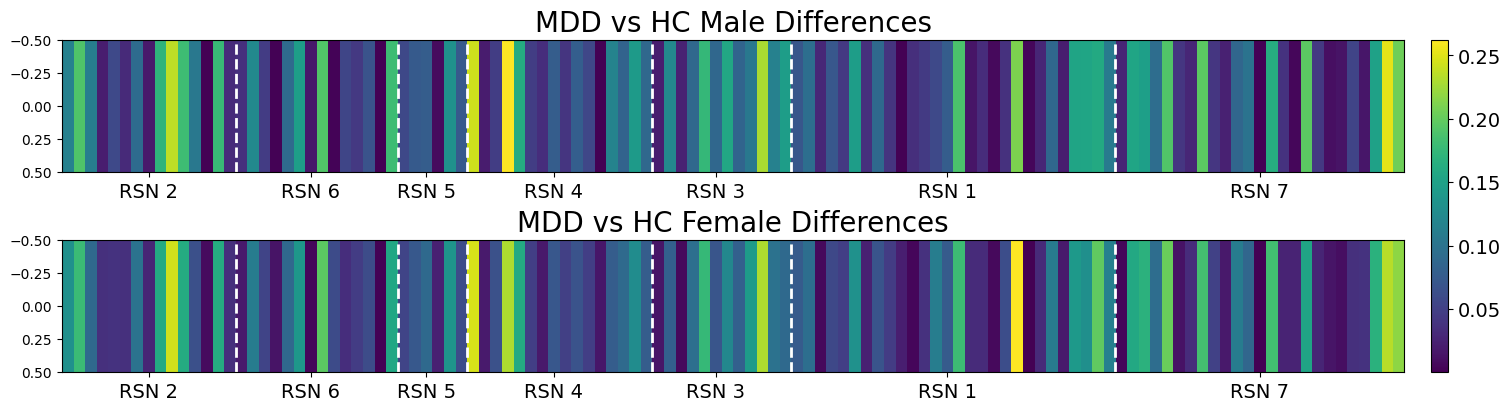

In [191]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4), constrained_layout=True)
cmap = 'viridis'  # 颜色映射

# 性别差异图
axs[0].imshow(heatmap_diff_male_sorted, aspect='auto', cmap=cmap)
axs[0].set_title("MDD vs HC Male Differences", fontsize=20)
axs[1].imshow(heatmap_diff_female_sorted, aspect='auto', cmap=cmap)
axs[1].set_title("MDD vs HC Female Differences", fontsize=20)

# 添加色标
cbar = fig.colorbar(axs[0].images[0], ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=14)  # 调整色标刻度字体大小

# 在每个RSN之间画分界线
for end in rsn_ends[:-1]:  # 最后一个分界线不需要绘制
    for ax in axs:
        ax.axvline(x=end + 0.5, color='white', linestyle='--', linewidth=2)

# 设置x轴刻度标签
for ax in axs:
    ax.set_xticks(rsn_midpoints)
    ax.set_xticklabels([f"RSN {label}" for label in rsn_data['rsn'].unique()], rotation=0, ha='center', fontsize=14)

plt.show()


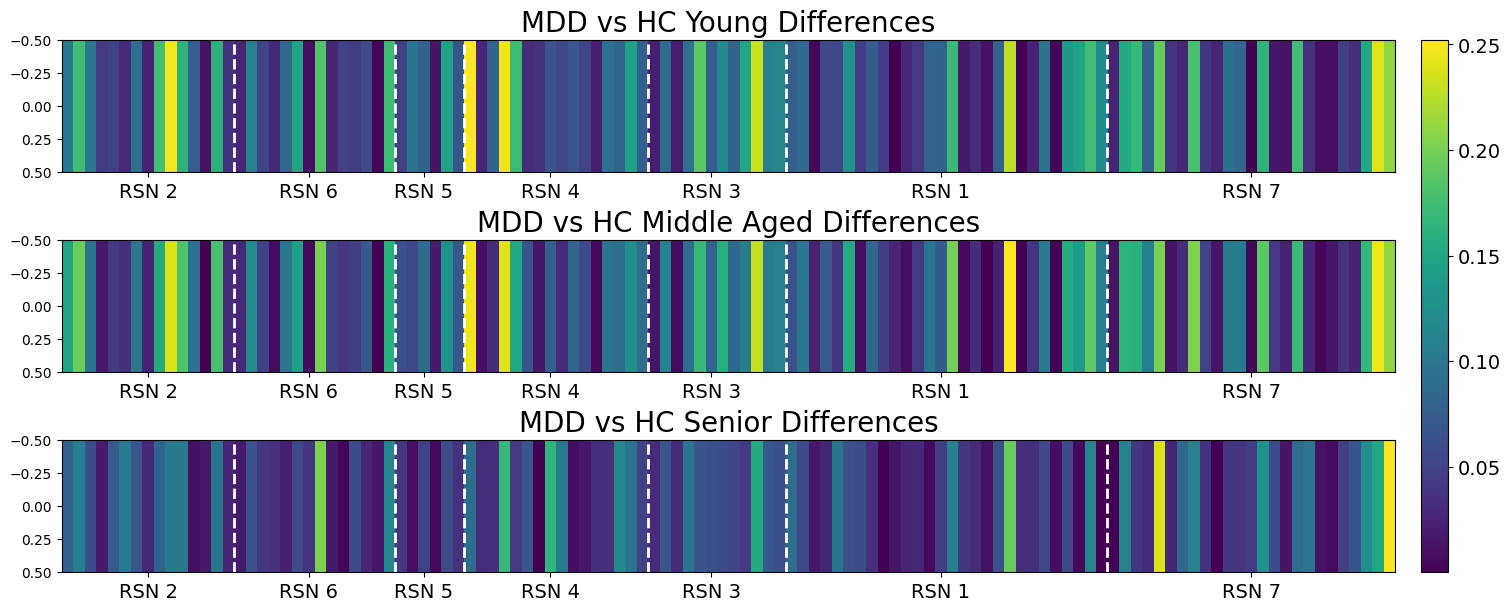

In [192]:
fig, axs = plt.subplots(3, 1, figsize=(15, 6), constrained_layout=True)
cmap = 'viridis'  # 颜色映射

# 年龄差异图
axs[0].imshow(heatmap_diff_young_sorted, aspect='auto', cmap=cmap)
axs[0].set_title("MDD vs HC Young Differences", fontsize=20)
axs[1].imshow(heatmap_diff_middle_aged_sorted, aspect='auto', cmap=cmap)
axs[1].set_title("MDD vs HC Middle Aged Differences", fontsize=20)
axs[2].imshow(heatmap_diff_senior_sorted, aspect='auto', cmap=cmap)
axs[2].set_title("MDD vs HC Senior Differences", fontsize=20)

# 添加色标
cbar = fig.colorbar(axs[0].images[0], ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=14)  # 调整色标刻度字体大小

# 在每个RSN之间画分界线
for end in rsn_ends[:-1]:  # 最后一个分界线不需要绘制
    for ax in axs:
        ax.axvline(x=end + 0.5, color='white', linestyle='--', linewidth=2)

# 设置x轴刻度标签
for ax in axs:
    ax.set_xticks(rsn_midpoints)
    ax.set_xticklabels([f"RSN {label}" for label in rsn_data['rsn'].unique()], rotation=0, ha='center', fontsize=14)

plt.show()
